# Intermediate Natural Language Processing (NLP)

## Agenda

1. Reading in the Yelp reviews corpus
2. Term Frequency-Inverse Document Frequency (TF-IDF)
3. Using TF-IDF to summarize a Yelp review
4. Sentiment analysis using TextBlob

In [1]:
# for Python 2: use print only as a function
from __future__ import print_function

## Part 1: Reading in the Yelp reviews corpus

In [6]:
# read yelp.csv into a DataFrame using a relative path
import pandas as pd
path = '../BT5153_data/yelp.csv'
yelp = pd.read_csv(path)

In [7]:
# examine the first row
yelp.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0


In [8]:
# create a new DataFrame that only contains the 5-star and 1-star reviews
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]
yelp_best_worst.shape

(4086, 10)

In [9]:
# define X and y
X = yelp_best_worst.text
y = yelp_best_worst.stars

In [10]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test(vect):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict the star rating
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    
    # print the accuracy of its predictions
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

## Part 2: Term Frequency-Inverse Document Frequency (TF-IDF)

- **What:** Compute the "relative frequency" that a word appears in a document compared to its frequency across all documents in the corpus
- **Why:** More useful than "term frequency" for identifying "important" words in each document (high frequency in that document, low frequency in other documents)
- **Notes:** Useful for search engine relevance scoring, text summarization, document clustering, and classification

In [12]:
# example documents
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

### Calculating Term Frequency (TF):

In [13]:
# Term Frequency (count the number of occurrences of each term in each document)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
tf = pd.DataFrame(vect.fit_transform(simple_train).toarray(), columns=vect.get_feature_names())
tf

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


### Calculating Document Frequency (DF):

In [14]:
# examine default parameters of CountVectorizer
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

[CountVectorizer documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

- **binary:** boolean, default=False
    - If True, all non-zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.

In [15]:
# use 'binary=True' parameter to check for occurrence (1) or non-occurrence (0)
vect = CountVectorizer(binary=True)
pd.DataFrame(vect.fit_transform(simple_train).toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,1,0,0


In [16]:
# Document Frequency (count the number of documents in which each term appears)
df = vect.fit_transform(simple_train).toarray().sum(axis=0)
pd.DataFrame(df.reshape(1, 6), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,1,3,2,1,1,1


### Calculating TF-IDF from TF and DF:

In [17]:
# TF-IDF (simple version)
tf/df

,cab,call,me,please,tonight,you
0,0.0,0.333333,0.0,0.0,1.0,1.0
1,1.0,0.333333,0.5,0.0,0.0,0.0
2,0.0,0.333333,0.5,2.0,0.0,0.0


[TfidfVectorizer documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [18]:
# TfidfVectorizer (CountVectorizer + TfidfTransformer)
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Note the extra parameters (compared to CountVectorizer):
- norm
- smooth_idf
- sublinear_tf
- use_idf 

In [19]:
# TF-IDF (scikit-learn's default implementation)
pd.DataFrame(vect.fit_transform(simple_train).toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0.000000,0.385372,0.000000,0.000000,0.652491,0.652491
1,0.720333,0.425441,0.547832,0.000000,0.000000,0.000000
2,0.000000,0.266075,0.342620,0.901008,0.000000,0.000000


### Using TF-IDF for classification:

In [20]:
# use CountVectorizer with default parameters
vect = CountVectorizer()
tokenize_test(vect)

Features:  16825
Accuracy:  0.9187866927592955


In [21]:
# use TfidfVectorizer with default parameters
vect = TfidfVectorizer()
tokenize_test(vect)

Features:  16825
Accuracy:  0.8199608610567515


In [22]:
# tune TfidfVectorizer for better results
vect = TfidfVectorizer(norm=None)
tokenize_test(vect)

Features:  16825
Accuracy:  0.9080234833659491


In [23]:
# make TfidfVectorizer behave like CountVectorizer
vect = TfidfVectorizer(norm=None, use_idf=False)
tokenize_test(vect)

Features:  16825
Accuracy:  0.9187866927592955


## Part 3: Using TF-IDF to summarize a Yelp review

Reddit's [autotldr](https://np.reddit.com/r/autotldr/comments/31b9fm/faq_autotldr_bot/) uses the [SMMRY](http://smmry.com/about) algorithm, which is based on TF-IDF!

In [24]:
# create a document-term matrix (minus stop words) using TfidfVectorizer
vect = TfidfVectorizer(stop_words='english')
dtm = vect.fit_transform(yelp.text)
dtm.shape

(10000, 28880)

In [25]:
# create a list of all of the features
features = vect.get_feature_names()
len(features)

28880

In [30]:
import numpy as np

def summarize():
    
    # choose a random review that is at least 400 characters
    review_length = 0
    while review_length < 400:
        review_id = np.random.randint(0, yelp.shape[0])
        review_text = yelp.loc[review_id, 'text']
        review_length = len(review_text)
    
    # create a list of all unique words in the review (minus stop words) using CountVectorizer
    vect = CountVectorizer(stop_words='english')
    vect.fit([review_text])
    unique_words = vect.get_feature_names()
    
    # create a dictionary of words and their TF-IDF scores
    word_scores = {}
    for word in unique_words:
        word_scores[word] = dtm[review_id, features.index(word)]
    
    # print words with the top 5 TF-IDF scores
    print('TOP SCORING WORDS:')
    top_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[0:5]
    for word, score in top_scores:
        print(word)
    
    # print 5 random words (for comparison)
    print('\n' + 'RANDOM WORDS:')
    random_words = np.random.choice(list(word_scores.keys()), size=5, replace=False)
    for word in random_words:
        print(word)
    
    # print the review
    print('\n' + review_text)

In [31]:
# summarize a random Yelp review
summarize()

TOP SCORING WORDS:
bar
sit
converse
burger
fries

RANDOM WORDS:
looking
speedy
like
just
place

I really like this bar & restaurant.  I usually come here to meet up with a friend and sit at the main bar.  It is modern and clean.  There are a couple bars to sit at and they even open a big door to a bar for the outside too.  They have some good brews on tap and have flat screen tv's as well.  

I have only had a burger and fries here.  They burger was really good, the fries were really greasy and were just okay.

The staff here is friendly & speedy.  I would recommend this place for a good place for someone looking for a nice place to grab a drink and converse.


## Part 4: Sentiment analysis using TextBlob

[TextBlob](https://textblob.readthedocs.org): "Simplified Text Processing"

In [32]:
# print the first review
print(yelp_best_worst.loc[0, 'text'])

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!


In [35]:
# save it as a TextBlob object
from textblob import TextBlob
review = TextBlob(yelp_best_worst.loc[0, 'text'])

In [36]:
# examine the words
review.words

WordList(['My', 'wife', 'took', 'me', 'here', 'on', 'my', 'birthday', 'for', 'breakfast', 'and', 'it', 'was', 'excellent', 'The', 'weather', 'was', 'perfect', 'which', 'made', 'sitting', 'outside', 'overlooking', 'their', 'grounds', 'an', 'absolute', 'pleasure', 'Our', 'waitress', 'was', 'excellent', 'and', 'our', 'food', 'arrived', 'quickly', 'on', 'the', 'semi-busy', 'Saturday', 'morning', 'It', 'looked', 'like', 'the', 'place', 'fills', 'up', 'pretty', 'quickly', 'so', 'the', 'earlier', 'you', 'get', 'here', 'the', 'better', 'Do', 'yourself', 'a', 'favor', 'and', 'get', 'their', 'Bloody', 'Mary', 'It', 'was', 'phenomenal', 'and', 'simply', 'the', 'best', 'I', "'ve", 'ever', 'had', 'I', "'m", 'pretty', 'sure', 'they', 'only', 'use', 'ingredients', 'from', 'their', 'garden', 'and', 'blend', 'them', 'fresh', 'when', 'you', 'order', 'it', 'It', 'was', 'amazing', 'While', 'EVERYTHING', 'on', 'the', 'menu', 'looks', 'excellent', 'I', 'had', 'the', 'white', 'truffle', 'scrambled', 'eggs', 

In [37]:
# examine the sentences
review.sentences

[Sentence("My wife took me here on my birthday for breakfast and it was excellent."),
 Sentence("The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure."),
 Sentence("Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning."),
 Sentence("It looked like the place fills up pretty quickly so the earlier you get here the better."),
 Sentence("Do yourself a favor and get their Bloody Mary."),
 Sentence("It was phenomenal and simply the best I've ever had."),
 Sentence("I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it."),
 Sentence("It was amazing."),
 Sentence("While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious."),
 Sentence("It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete."),
 Sentence("It was the best "toast" I've ever had."),


Sentiment is the "attitude" of the speaker:

- **polarity** ranges from -1 (most negative) to 1 (most positive)
- **subjectivity** ranges from 0 (very objective) to 1 (very subjective)

In [38]:
# examine the review sentiment
print(review.sentiment.polarity)
print(review.sentiment.subjectivity)

0.40246913580246907
0.6591122868900646


In [39]:
# quick aside: understanding the apply method
yelp['length'] = yelp.text.apply(len)
yelp.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345


In [40]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    
    # use this line for Python 2 (avoids UnicodeDecodeError for some reviews)
    # blob = TextBlob(text.decode(encoding='utf-8'))
    
    # use this line instead for Python 3
    blob = TextBlob(text)
    
    # return the polarity
    return blob.sentiment.polarity

In [41]:
# create a new DataFrame column for sentiment (WARNING: SLOW!)
yelp['sentiment'] = yelp.text.apply(detect_sentiment)
yelp.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,sentiment
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889,0.402469
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345,0.229773
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76,0.566667


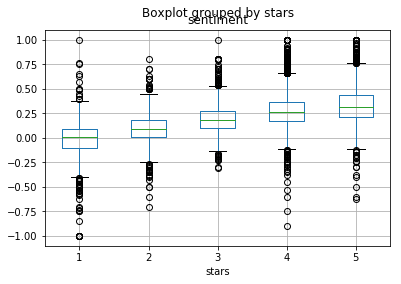

In [42]:
# box plot of sentiment grouped by stars
# import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
yelp.boxplot('sentiment', by='stars')

In [43]:
# reviews with most positive sentiment
yelp.loc[yelp.sentiment == 1, 'text'].head()

254    Our server Gary was awesome. Food was amazing....
347    3 syllables for this place. \nA-MAZ-ING!\n\nTh...
420                                    LOVE the food!!!!
459    Love it!!! Wish we still lived in Arizona as C...
679                                     Excellent burger
Name: text, dtype: object

In [44]:
# reviews with most negative sentiment
yelp.loc[yelp.sentiment == -1, 'text'].head()

773     This was absolutely horrible. I got the suprem...
1517                  Nasty workers and over priced trash
3266    Absolutely awful... these guys have NO idea wh...
4766                                       Very bad food!
5812        I wouldn't send my worst enemy to this place.
Name: text, dtype: object

In [45]:
# widen the column display
pd.set_option('display.max_colwidth', 500)

In [46]:
# negative sentiment in a 5-star review
yelp.loc[(yelp.stars == 5) & (yelp.sentiment < -0.3), 'text'].head(1)

390    RIP AZ Coffee Connection.  :(  I stopped by two days ago unaware that they had closed.  I am severely bummed.  This place is irreplaceable!  Damn you, Starbucks and McDonalds!
Name: text, dtype: object

In [47]:
# positive sentiment in a 1-star review
yelp.loc[(yelp.stars == 1) & (yelp.sentiment > 0.5), 'text'].head(1)

1781    If you like the stuck up Scottsdale vibe this is a good place for you. The food isn't impressive. Nice outdoor seating.
Name: text, dtype: object

In [48]:
# reset the column display width
pd.reset_option('display.max_colwidth')